Header

INFO:: 02-29 18:32:37:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 02-29 18:32:37:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 02-29 18:32:37:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 02-29 18:32:37:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU


[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
 -6.50468410e-08+9.93322861e-09j  6.94855761e-08-1.10898411e-08j]
(1, 2100225) complex128 [[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
   2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
  -6.50468410e-08+9.93322861e-09j  6.94855761e-08-1.10898411e-08j]]


/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc

** gclm2lenmap: inconsistent input dtype !
[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
 -0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
(1, 2100225) complex128 [[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
   2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
  -0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]]
deflection std is 2.64e+00 amin
deflection std is 2.64e+00 amin
build_angles


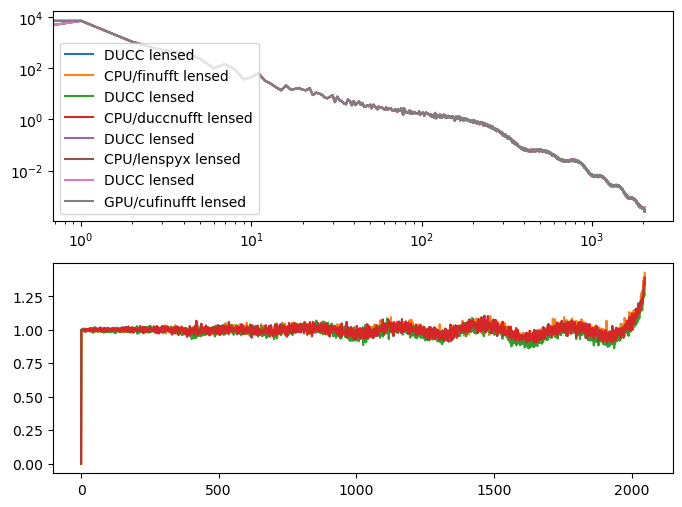

In [16]:
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import cupy as cp
import pysht
from pysht import get_geom
import delensalot
from delensalot import utils
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs

lmax, mmax = 2048, 2048
ll = np.arange(0,lmax)
# geominfo = ('tgl',{'lmax': lmax, 'smax':3})
geominfo = ('gl',{'lmax':lmax})
# geominfo = ('cc',{'nphi':1032, 'ntheta':2058})
# geominfo = ('healpix',{'nside': 512})

synunl = Xunl(lmax=lmax, geominfo=geominfo)
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo)

philm = synunl.get_sim_phi(0, space='alm')
dlm = hp.almxfl(philm, np.sqrt(ll*(ll+1)))

Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
Tunlmap = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')
Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')

# Check calls

## nuFFT test

### CPU

In [3]:
"""
CPU nuFFT
"""
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}
sht_solver = 'ducc' # 'shtns'
for solver in ['finufft', 'duccnufft']:
    for backend in ['CPU']:
        for mode in ['nuFFT']:
            t = pysht.get_transformer(solver, mode, backend)

            # print("Testing function synthesis_general...")
            # defres = t.synthesis_general(lmax, mmax, Tsky, [0,1], 0, 1e-5, 4, mode='GRAD_ONLY', verbose=1)
            
            # print("Testing function adjoint_synthesis_general...")
            # defres = t.adjoint_synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)

            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)
            print("\n----Testing function gclm2lenmap...----")
            defres = t.gclm2lenmap(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)

            print("\n----Testing function lenmap2gclm...----")
            defres = t.lenmap2gclm(points=Tsky.copy(), dlm=dlm, spin=0, lmax=lmax, mmax=lmax, nthreads=4)
            
            print("\n----Testing function lensgclm...----")
            defres = t.lensgclm(Tunl.copy(), spin=0, dlm=dlm, lmax_out=lmax, nthreads=4)

            print('\n\n')

Testing solver=finufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----
theta= [2.34502727e-03 5.38281608e-03 8.43854468e-03 ... 3.13315411e+00
 3.13620984e+00 3.13924763e+00] phi0= [0. 0. 0. ... 0. 0. 0.] nphi= [2160 2160 2160 ... 2160 2160 2160] ringstart= [      0    2160    4320 ... 2207520 2209680 2211840] deflect= [[-1.72298596e-04  5.91913047e-05]
 [-1.72128662e-04  6.04905142e-05]
 [-1.71954519e-04  6.17891300e-05]
 ...
 [-1.17377960e-03  4.16780324e-05]
 [-1.17370298e-03  3.82913768e-05]
 [-1.17361471e-03  3.49062866e-05]] calc_rotation= True nthreads= 4
build_angles


/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc


----Testing function lenmap2gclm...----

----Testing function lensgclm...----


/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc




Testing solver=duccnufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----
theta= [2.34502727e-03 5.38281608e-03 8.43854468e-03 ... 3.13315411e+00
 3.13620984e+00 3.13924763e+00] phi0= [0. 0. 0. ... 0. 0. 0.] nphi= [2160 2160 2160 ... 2160 2160 2160] ringstart= [      0    2160    4320 ... 2207520 2209680 2211840] deflect= [[-1.72298596e-04  5.91913047e-05]
 [-1.72128662e-04  6.04905142e-05]
 [-1.71954519e-04  6.17891300e-05]
 ...
 [-1.17377960e-03  4.16780324e-05]
 [-1.17370298e-03  3.82913768e-05]
 [-1.17361471e-03  3.49062866e-05]] calc_rotation= True nthreads= 4
build_angles

----Testing function lenmap2gclm...----

----Testing function lensgclm...----





### GPU

In [ ]:
"""
GPU nuFFT
"""
sht_solver = 'ducc' # shtns
for solver in ['cufinufft']:
    for backend in ['GPU']:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)
            # t.set_geometry(geominfo)
            print("\n----Testing function gclm2lenmap...----")
            defres = t.gclm2lenmap(gclm=Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)

            print("\n----Testing function lenmap2gclm...----")
            defres = t.lenmap2gclm(points=Tsky.copy(), dlm=dlm, spin=0, lmax=lmax, mmax=lmax, nthreads=4)
            
            print("\n----Testing function lensgclm...----")
            defres = t.lensgclm(Tunl.copy(), spin=0, lmax_out=lmax, dlm=dlm, nthreads=4)

            print("Testing function synthesis_general...")
            defres = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            print("Testing function adjoint_synthesis_general...")
            defres = t.adjoint_synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            print('\n\n')

## SHT test

### CPU

In [ ]:

"""
CPU SHT
"""
for solver in ['shtns', 'ducc']:
    for backend in ['CPU']:
        for mode in ['SHT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)(geominfo)

            print("Testing function synthesis_general...")
            defres = t.synthesis(Tunl.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            print("Testing function adjoint_synthesis_general...")
            if solver == 'shtns':
                m = np.random.random(size=t.constructor.spat_shape)
            else:
                m = Tsky
            defres = t.adjoint_synthesis(m.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            print('\n\n')

### GPU

In [ ]:
"""
GPU SHT
"""
for solver in ['shtns']:
    for backend in ['GPU']:
        for mode in ['SHT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)(geominfo)

            print("Testing function synthesis_general...")
            defres = t.synthesis(Tunl.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            print("Testing function adjoint_synthesis_general...")
            if solver == 'shtns':
                m = np.random.random(size=t.constructor.spat_shape)
            else:
                m = Tsky
            defres = t.adjoint_synthesis(m.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            print('\n\n')

# Check output
## deflection

Testing solver=cufinufft backend=GPU mode=nuFFT...
deflection std is 2.64e+00 amin

----Testing function gclm2lenmap...----


deflection std is 2.64e+00 amin
build_angles



Testing solver=finufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----


/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc




Testing solver=duccnufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----



Testing solver=lenspyx backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----
** gclm2lenmap: inconsistent input dtype !
[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
 -0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
(1, 2100225) complex128 [[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
   2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
  -0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]]





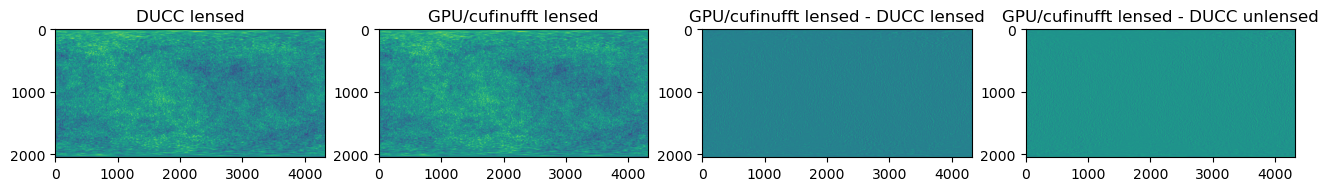

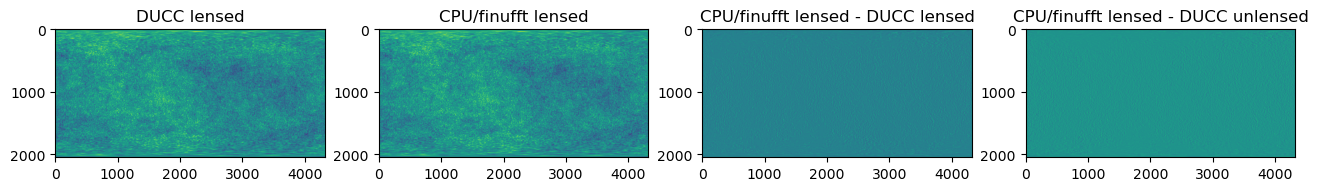

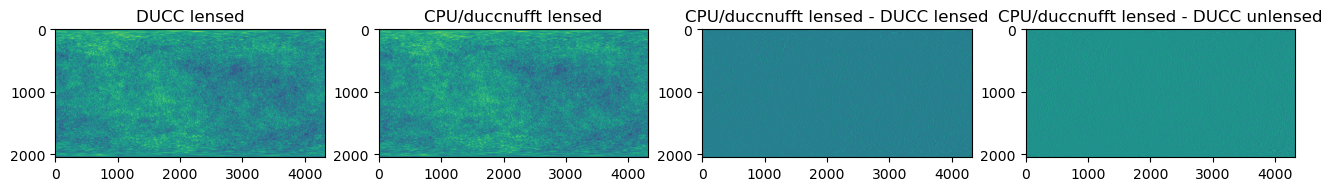

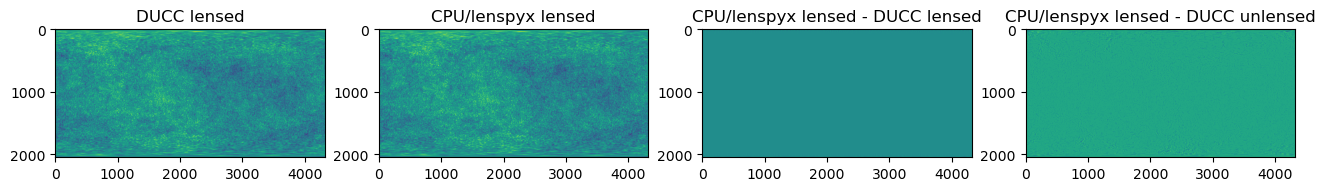

In [3]:
"""
gclm2lenmap
"""
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}


for backend in ['GPU', 'CPU']:
    if backend == 'GPU':
        solvers = ['cufinufft']
    elif backend == 'CPU':
        solvers = ['finufft', 'duccnufft', 'lenspyx']
    sht_solver = 'ducc' # 'shtns'

    for solver in solvers:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            print("\n----Testing function gclm2lenmap...----")
            defres = t.gclm2lenmap(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            fig, ax = plt.subplots(1,4,figsize=(16,6))
            ax[0].imshow(Tsky.reshape(lmax+1,-1))
            ax[0].set_title('DUCC lensed'.format(solver=solver))
            ax[1].imshow(defres.reshape(lmax+1,-1))
            ax[1].set_title('{backend}/{solver} lensed'.format(solver=solver, backend=backend))
            ax[2].imshow((Tsky-defres).reshape(lmax+1,-1))
            ax[2].set_title('{backend}/{solver} lensed - DUCC lensed'.format(solver=solver, backend=backend))
            ax[3].imshow((Tunlmap-defres).reshape(lmax+1,-1))
            ax[3].set_title('{backend}/{solver} lensed - DUCC unlensed'.format(solver=solver, backend=backend))

            print('\n\n')

Testing solver=finufft backend=CPU mode=nuFFT...

----Testing function lenmap2gclm...----
theta= [2.34502727e-03 5.38281608e-03 8.43854468e-03 ... 3.13315411e+00
 3.13620984e+00 3.13924763e+00] phi0= [0. 0. 0. ... 0. 0. 0.] nphi= [2160 2160 2160 ... 2160 2160 2160] ringstart= [      0    2160    4320 ... 2207520 2209680 2211840] deflect= [[-1.72298596e-04  5.91913047e-05]
 [-1.72128662e-04  6.04905142e-05]
 [-1.71954519e-04  6.17891300e-05]
 ...
 [-1.17377960e-03  4.16780324e-05]
 [-1.17370298e-03  3.82913768e-05]
 [-1.17361471e-03  3.49062866e-05]] calc_rotation= True nthreads= 4
build_angles


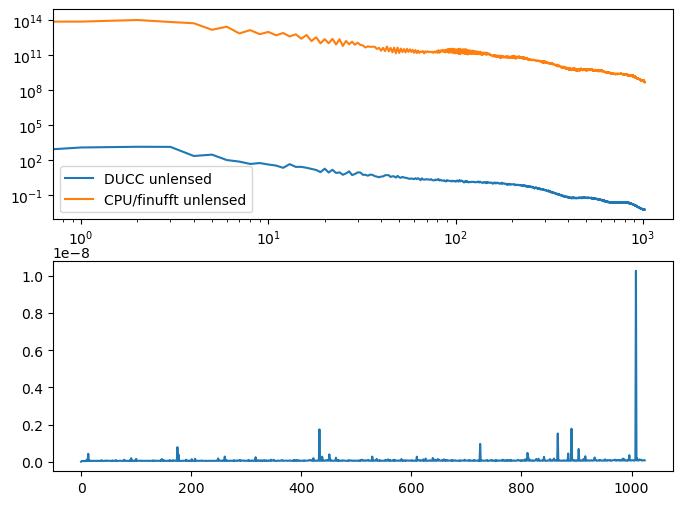

Testing solver=duccnufft backend=CPU mode=nuFFT...

----Testing function lenmap2gclm...----
theta= [2.34502727e-03 5.38281608e-03 8.43854468e-03 ... 3.13315411e+00
 3.13620984e+00 3.13924763e+00] phi0= [0. 0. 0. ... 0. 0. 0.] nphi= [2160 2160 2160 ... 2160 2160 2160] ringstart= [      0    2160    4320 ... 2207520 2209680 2211840] deflect= [[-1.72298596e-04  5.91913047e-05]
 [-1.72128662e-04  6.04905142e-05]
 [-1.71954519e-04  6.17891300e-05]
 ...
 [-1.17377960e-03  4.16780324e-05]
 [-1.17370298e-03  3.82913768e-05]
 [-1.17361471e-03  3.49062866e-05]] calc_rotation= True nthreads= 4
build_angles


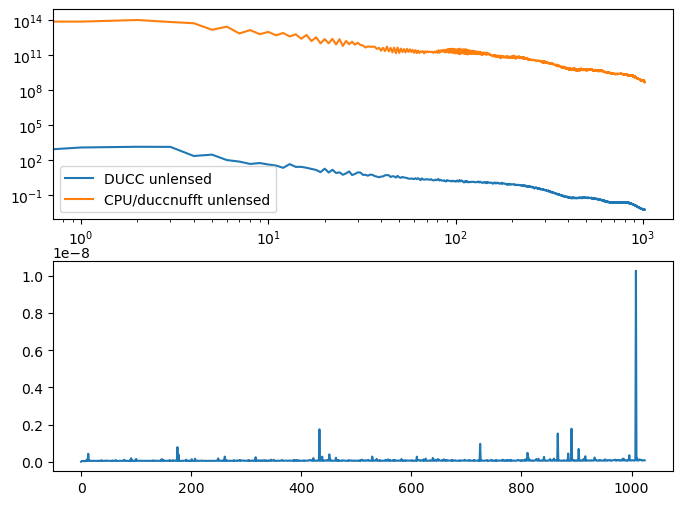

In [10]:
import healpy as hp
"""
lenmap2gclm
"""
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}
backend = 'CPU'
if backend == 'GPU':
    solvers = ['cufinufft']
elif backend == 'CPU':
    solvers = ['finufft', 'duccnufft', 'lenspyx']
sht_solver = 'ducc' # 'shtns'


for solver in solvers:
    fig, ax = plt.subplots(2,1,figsize=(8,6))
    for mode in ['nuFFT']:
        print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
        t = pysht.get_transformer(solver, mode, backend)
        t = t(sht_solver, geominfo, deflection_kwargs)

        print("\n----Testing function lenmap2gclm...----")
        defres = t.lenmap2gclm(points=Tsky.copy(), dlm=dlm, spin=0, lmax=lmax, mmax=lmax, nthreads=4)
        
        ax[0].plot(hp.alm2cl(Tunl), label='DUCC unlensed')
        ax[0].plot(hp.alm2cl(defres), label='{backend}/{solver} unlensed'.format(solver=solver, backend=backend))
        ax[1].plot(hp.alm2cl(Tunl/defres), label='DUCC - {backend}/{solver} unlensed'.format(solver=solver, backend=backend))
    ax[0].loglog()
    ax[0].legend()
    plt.show()

/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc

** gclm2lenmap: inconsistent input dtype !
[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
 -0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
(1, 2100225) complex128 [[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
   2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
  -0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]]
deflection std is 2.64e+00 amin
deflection std is 2.64e+00 amin
build_angles


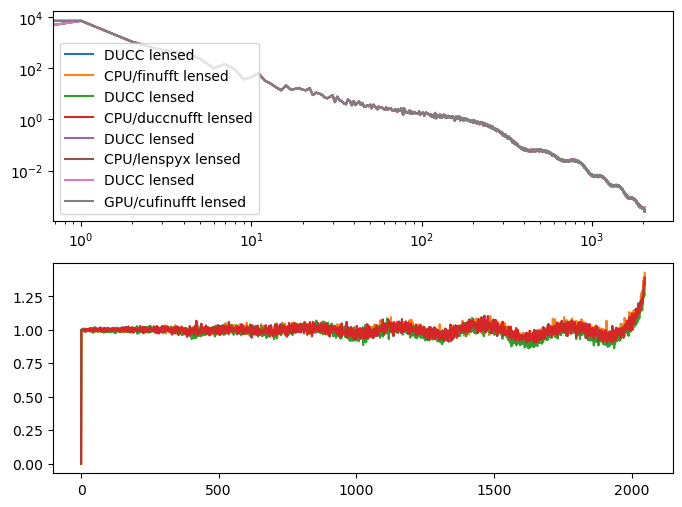

In [17]:
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}

fig, ax = plt.subplots(2,1,figsize=(8,6))
for backend in ['CPU', 'GPU']:
    if backend == 'GPU':
        solvers = ['cufinufft']
    elif backend == 'CPU':
        solvers = ["finufft", "duccnufft", "lenspyx"] #   
    sht_solver = 'ducc' # 'shtns'
    for solver in solvers:
        for mode in ['nuFFT']:
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            defres = t.lensgclm(Tunl.copy(), spin=0, dlm=dlm, lmax_out=lmax, nthreads=4)
                
            ax[0].plot(hp.alm2cl(Tunl), label='DUCC lensed')
            ax[0].plot(hp.alm2cl(defres.astype(complex)), label='{backend}/{solver} lensed'.format(solver=solver, backend=backend))
            ax[1].plot(hp.alm2cl(Tunl)/hp.alm2cl(defres.astype(complex)), label='DUCC - {backend}/{solver} lensed'.format(solver=solver, backend=backend))
        ax[0].loglog()
        ax[0].legend()
plt.show()

## SHT

In [ ]:
backend = 'CPU'
if backend == 'GPU':
    solvers = ['shtns']
elif backend == 'CPU':
    solvers = ['ducc', 'duccnufft']
sht_solver = 'ducc' # 'shtns'

for solver in solvers:
    for mode in ['SHT']:
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            defres = t.synthesis(Tunl.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            fig, ax = plt.subplots(1,4,figsize=(16,6))
            ax[0].imshow(Tsky.reshape(lmax+1,-1))
            ax[0].set_title('DUCC lensed'.format(solver=solver))
            ax[1].imshow(defres.reshape(lmax+1,-1))
            ax[1].set_title('{solver} lensed'.format(solver=solver))
            ax[2].imshow((Tsky-defres).reshape(lmax+1,-1))
            ax[2].set_title('{solver} lensed - DUCC lensed'.format(solver=solver))
            ax[3].imshow((Tunlmap-defres).reshape(lmax+1,-1))
            ax[3].set_title('{solver} lensed - DUCC unlensed'.format(solver=solver))
            
            print('\n\n')

In [ ]:
backend = ['CPU']
if backend == 'GPU':
    solvers = ['cufinufft']
elif backend == 'CPU':
    solvers = ['finufft', 'duccnufft']
sht_solver = 'ducc' # 'shtns'

for solver in solvers:
    for mode in ['SHT']:
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            if solver == 'shtns':
                m = np.random.random(size=t.constructor.spat_shape)
            else:
                m = Tsky
            defres = t.adjoint_synthesis(m.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            print('\n\n')
            
            fig, ax = plt.subplots(1,4,figsize=(16,6))
            ax[0].imshow(Tsky.reshape(lmax+1,-1))
            ax[0].set_title('DUCC lensed'.format(solver=solver))
            ax[1].imshow(defres.reshape(lmax+1,-1))
            ax[1].set_title('{solver} lensed'.format(solver=solver))
            ax[2].imshow((Tsky-defres).reshape(lmax+1,-1))
            ax[2].set_title('{solver} lensed - DUCC lensed'.format(solver=solver))
            ax[3].imshow((Tunlmap-defres).reshape(lmax+1,-1))
            ax[3].set_title('{solver} lensed - DUCC unlensed'.format(solver=solver))
            

            
            # print("\n----Testing function lensgclm...----")
            # defres = t.lensgclm(Tunl.copy(), spin=0, dlm=dlm, lmax_out=lmax, nthreads=4)

            print('\n\n')